# Ejemplo de Clustering

In [1]:
import pandas as pd
import numpy as np
from wrangler import Wrangler
from wrangler.data import PandasDataset, CSVDataset
import wrangler.transformers as tr
import wrangler.transformers.text as text_tr
import wrangler.transformers.ml as ml_tr
import wrangler.transformers.numeric as n_tr
from wrangler import logger as wrangler_logger
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

# Uncomment for console logging 
wrangler_logger.enable()

In [2]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
n_features = 10
n_centers = 3
X, _ = make_blobs(n_samples=200, centers=n_centers, n_features=n_features, random_state=0)
X = pd.DataFrame(X, columns = [f'Var{var}' for var in range(X.shape[1])])

X[f'Var{n_features}'] = X['Var0'].apply(lambda x: "Cat1" if np.random.rand()<0.5 else "Cat2")
X[f'Var{n_features+1}'] = X['Var0'].apply(lambda x: np.random.choice([f"Cat{n}" for n in range(10)]))

X_train, X_test = train_test_split(X, test_size=0.1)

In [3]:
X_train

,Var0,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11
181,8.359499,6.266941,-1.052609,4.452380,-9.253871,2.287380,-5.392305,8.599893,1.354188,-1.763804,Cat1,Cat2
137,0.667156,4.070321,3.787989,1.582165,-1.156079,3.059944,0.271739,9.555049,10.202760,-1.748945,Cat1,Cat5
117,7.980919,5.986394,-1.827886,5.054598,-7.607773,2.981871,-7.603677,9.166175,1.254944,-1.985675,Cat2,Cat6
56,6.041191,1.108941,1.600037,9.909829,-8.524107,-7.958437,-7.947128,5.102383,5.107310,8.826402,Cat2,Cat7
19,5.627556,-0.100197,2.114883,9.577248,-7.593961,-7.490494,-9.193007,4.876509,7.232386,7.702232,Cat2,Cat3
...,...,...,...,...,...,...,...,...,...,...,...,...
189,6.764909,0.402582,-0.061029,10.509889,-9.435828,-9.799001,-7.001207,6.248365,4.101402,6.716803,Cat2,Cat9
1,7.393435,5.353521,-1.423697,5.689098,-7.216711,1.558204,-6.232880,10.695621,0.228681,-0.132390,Cat1,Cat4
35,0.936987,3.135694,2.578544,0.726117,-0.755113,3.741386,0.914980,9.171988,8.904073,-2.570549,Cat2,Cat7
152,5.045832,1.672537,1.595713,10.644086,-7.642833,-8.292509,-8.330554,6.863894,4.858214,8.080218,Cat2,Cat1


In [4]:
wrangler = Wrangler()

2022-02-25 at 10:52:41 | INFO | catalog | Adding dataset: intermediate


In [5]:
cluster_input = PandasDataset('cluster_inputs', X_train)

In [6]:
wrangler.add_dataset(cluster_input)

2022-02-25 at 10:52:41 | INFO | catalog | Adding dataset: cluster_inputs


In [7]:
def skewed_transformation(x):
    return np.sqrt(x**2)

# def skewed_transformation(x):
#     return np.log(x+1)

wrangler.add_node(
    name = 'skewed evaluation',
    transformer = n_tr.SkewedDataEvaluator(
        threshold = 0.5,
        function = skewed_transformation
    ),
    inputs=['cluster_inputs'],
    outputs=['cluster_transformed'],
)


2022-02-25 at 10:52:41 | INFO | pipeline | Node skewed evaluation added to Pipeline 


In [8]:
wrangler.add_node(
    name = 'ordinal encoder',
    transformer = text_tr.OrdinalEncoderTransformer(columns=['Var10']),
    inputs = ['cluster_transformed'],
    outputs = ['cluster_transformed']
)


2022-02-25 at 10:52:41 | INFO | pipeline | Node ordinal encoder added to Pipeline 


In [9]:
wrangler.add_node(
    name = 'one hot encoder',
    transformer = text_tr.OneHotEncoderTransformer(column='Var11'),
    inputs = ['cluster_transformed'],
    outputs = ['cluster_transformed']
)



2022-02-25 at 10:52:42 | INFO | pipeline | Node one hot encoder added to Pipeline 


In [15]:
wrangler.add_node(
    name='pca reduction',
    transformer = n_tr.DimensionReducerTransformer(
        n_components=0.95, 
        mode = 'pca'
    ),
    inputs = ['cluster_transformed'],
    outputs = ['cluster_reduced'],
)

2022-02-25 at 10:53:35 | WARNING | pipeline | Replacing Existing Node: pca reduction
2022-02-25 at 10:53:35 | INFO | pipeline | Node pca reduction added to Pipeline 


In [16]:
wrangler.fit_transform()

2022-02-25 at 10:53:35 | INFO | node | Running Node: skewed evaluation
2022-02-25 at 10:53:35 | INFO | base | Loading PandasDataset(name='cluster_inputs', data=DataFrame)
2022-02-25 at 10:53:35 | DEBUG | base | Fitting SkewedDataEvaluator(threshold=0.5, function=<function skewed_transformation at 0x00000271C843A940>, skewed_cols=['Var4', 'Var5', 'Var9', 'Var4', 'Var5', 'Var9'])
2022-02-25 at 10:53:35 | DEBUG | base | Transforming SkewedDataEvaluator(threshold=0.5, function=<function skewed_transformation at 0x00000271C843A940>, skewed_cols=['Var4', 'Var5', 'Var9', 'Var4', 'Var5', 'Var9', 'Var4', 'Var5', 'Var9'])
2022-02-25 at 10:53:35 | INFO | base | Saving PandasDataset(name='cluster_transformed', data=DataFrame)
2022-02-25 at 10:53:35 | INFO | node | Running Node: ordinal encoder
2022-02-25 at 10:53:35 | INFO | base | Loading PandasDataset(name='cluster_transformed', data=DataFrame)
2022-02-25 at 10:53:35 | DEBUG | base | Fitting OrdinalEncoderTransformer(columns=['Var10'], encoder=O

In [18]:
# wrangler.data_catalog.load('cluster_reduced')

In [51]:
from sklearn.cluster import KMeans

# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse


# max_k = 10
# wss = calculate_WSS(X_train.iloc[:,:4].values, max_k)
# elbow_results = pd.DataFrame(wss, index=[i for i in range(2, max_k+1)], columns=['wss'])

# elbow_results['wss'].diff(periods=1)
# plt.plot(elbow_results)

In [52]:
# imports
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from joblib import Parallel, delayed

def kMeansRes(data, k, alpha_k=0.02):
    inertia_o = np.square((data - data.mean(axis=0))).sum()
    kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
    return scaled_inertia

def chooseBestKforKMeansParallel(data, max_k):
    ans = Parallel(n_jobs=-1,verbose=10)(delayed(kMeansRes)(data, k) for k in range(2,max_k+1))
    ans = list(zip(range(2,max_k+1),ans))
    results = pd.DataFrame(ans, columns = ['k','Scaled Inertia']).set_index('k')
    best_k = results.idxmin()[0]
    return best_k, results

def chooseBestKforKMeans(data, max_k):
    ans = []
    for k in range(2, max_k+1):
        scaled_inertia = kMeansRes(data, k)
        ans.append((k, scaled_inertia))
    results = pd.DataFrame(ans, columns = ['k','Scaled Inertia']).set_index('k')
    best_k = results.idxmin()[0]
    return best_k, results


In [53]:

# best_k, results = chooseBestKforKMeansParallel(X_train.iloc[:,:4].values, max_k)
# best_k, results = chooseBestKforKMeans(X_train.iloc[:,:4].values, max_k)
# plt.plot(results)
# print(best_k)

In [19]:
wrangler.add_node(
    name='kmeans cluster',
    transformer = ml_tr.KMeansModelTransformer(
        n_clusters=3
    ),
    inputs = ['cluster_reduced'],
    outputs = ['cluster_outputs'],
)

2022-02-25 at 10:53:46 | INFO | pipeline | Node kmeans cluster added to Pipeline 


In [20]:
wrangler.fit_transform()

2022-02-25 at 10:53:46 | INFO | node | Running Node: skewed evaluation
2022-02-25 at 10:53:46 | INFO | base | Loading PandasDataset(name='cluster_inputs', data=DataFrame)
2022-02-25 at 10:53:46 | DEBUG | base | Fitting SkewedDataEvaluator(threshold=0.5, function=<function skewed_transformation at 0x00000271C843A940>, skewed_cols=['Var4', 'Var5', 'Var9', 'Var4', 'Var5', 'Var9', 'Var4', 'Var5', 'Var9'])
2022-02-25 at 10:53:47 | DEBUG | base | Transforming SkewedDataEvaluator(threshold=0.5, function=<function skewed_transformation at 0x00000271C843A940>, skewed_cols=['Var4', 'Var5', 'Var9', 'Var4', 'Var5', 'Var9', 'Var4', 'Var5', 'Var9', 'Var4', 'Var5', 'Var9'])
2022-02-25 at 10:53:47 | INFO | base | Saving PandasDataset(name='cluster_transformed', data=DataFrame)
2022-02-25 at 10:53:47 | INFO | node | Running Node: ordinal encoder
2022-02-25 at 10:53:47 | INFO | base | Loading PandasDataset(name='cluster_transformed', data=DataFrame)
2022-02-25 at 10:53:47 | DEBUG | base | Fitting Ordina

In [25]:
# cluster_transformed
# wrangler.data_catalog.load('cluster_reduced').join(
# wrangler.data_catalog.load('cluster_outputs')    
# )

In [26]:
# cluster_input = PandasDataset('cluster_inputs', X_train)
# wrangler.add_dataset(cluster_input)

2022-02-25 at 10:56:29 | INFO | base | Loading PandasDataset(name='cluster_reduced', data=DataFrame)
2022-02-25 at 10:56:29 | INFO | base | Loading PandasDataset(name='cluster_outputs', data=DataFrame)


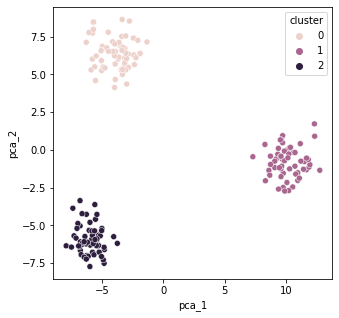

In [28]:
data = wrangler.data_catalog.load('cluster_reduced')
labels = wrangler.data_catalog.load('cluster_outputs')

data_labels = pd.concat([data,labels],axis=1)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
sns.scatterplot(x = data_labels.iloc[:,0],y = data_labels.iloc[:,1], hue=data_labels.iloc[:,-1])
plt.show()

In [31]:
data_features = wrangler.data_catalog.load('cluster_inputs')
data_labels = wrangler.data_catalog.load('cluster_outputs')

data = pd.concat([data_features, data_labels], axis=1)

2022-02-25 at 10:58:24 | INFO | base | Loading PandasDataset(name='cluster_inputs', data=DataFrame)
2022-02-25 at 10:58:24 | INFO | base | Loading PandasDataset(name='cluster_outputs', data=DataFrame)


In [32]:
# data.reset_index()
data

,Var0,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,cluster
181,8.359499,6.266941,-1.052609,4.452380,-9.253871,2.287380,-5.392305,8.599893,1.354188,-1.763804,Cat1,Cat2,0
137,0.667156,4.070321,3.787989,1.582165,-1.156079,3.059944,0.271739,9.555049,10.202760,-1.748945,Cat1,Cat5,1
117,7.980919,5.986394,-1.827886,5.054598,-7.607773,2.981871,-7.603677,9.166175,1.254944,-1.985675,Cat2,Cat6,0
56,6.041191,1.108941,1.600037,9.909829,-8.524107,-7.958437,-7.947128,5.102383,5.107310,8.826402,Cat2,Cat7,2
19,5.627556,-0.100197,2.114883,9.577248,-7.593961,-7.490494,-9.193007,4.876509,7.232386,7.702232,Cat2,Cat3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,6.764909,0.402582,-0.061029,10.509889,-9.435828,-9.799001,-7.001207,6.248365,4.101402,6.716803,Cat2,Cat9,2
1,7.393435,5.353521,-1.423697,5.689098,-7.216711,1.558204,-6.232880,10.695621,0.228681,-0.132390,Cat1,Cat4,0
35,0.936987,3.135694,2.578544,0.726117,-0.755113,3.741386,0.914980,9.171988,8.904073,-2.570549,Cat2,Cat7,1
152,5.045832,1.672537,1.595713,10.644086,-7.642833,-8.292509,-8.330554,6.863894,4.858214,8.080218,Cat2,Cat1,2


In [33]:
def compute_afinidades(data, columna_index='index', columna_cluster='cluster', columnas_ignorar = []):
    df_aux = data[data.columns.difference(columnas_ignorar)]

    categorical = df_aux.select_dtypes(include= ['int8', 'bool']).columns.tolist()

    numerical = df_aux.select_dtypes(include= ['number'], exclude= ['int8']).columns.tolist()

    if len(columnas_ignorar) != 0:
        for remove_col in columnas_ignorar:
            try: numerical.remove(remove_col)
            except: continue

    #Get stats by cluster
    aux = df_aux[numerical].groupby(columna_cluster).describe().T
    aux_ = aux.stack().reset_index(drop = False)
    aux_.rename(columns = {'level_0': 'variables', 'level_1': 'estadisticos', columna_cluster: 'cluster', 0: 'valor'}, inplace = True)

    #Get general stats
    numerical.remove(columna_cluster)
    aux2 = df_aux[numerical].describe().T
    aux_2 = aux2.stack().reset_index(drop = False)
    aux_2['cluster'] = 'Total'
    aux_2.rename(columns = {'level_0': 'variables', 'level_1': 'estadisticos', 0: 'valor'}, inplace = True)
    estadisticos = pd.concat([aux_, aux_2])

    #Get cluster means
    afin_ = df_aux[df_aux.columns.difference([columna_index])].groupby(columna_cluster).mean()

    #Get general means
    aux_afin = df_aux[df_aux.columns.difference([columna_cluster] + [columna_index])].mean()
    for col in afin_.columns:
        afin_[col] = afin_[col] / aux_afin[col]

    afin_ = afin_.stack().reset_index()
    
    afin_.rename(columns = {
        'level_1': 'variables', 
        columna_cluster: 'afinidad_cluster', 
        0: 'valor'
        }, 
        inplace = True
    )

    return estadisticos, afin_.sort_values(by=['afinidad_cluster','valor'],ascending=False)

estadisticos, afinidades = compute_afinidades(data)

In [37]:
# estadisticos
# afinidades

<AxesSubplot:xlabel='afinidad_cluster', ylabel='variables'>

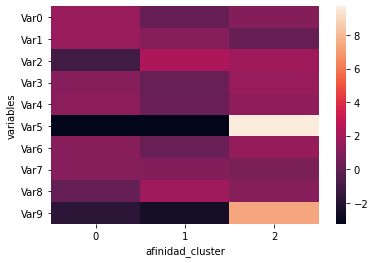

In [36]:
sns.heatmap(afinidades.pivot(
    index = 'variables',
    columns='afinidad_cluster',
    values='valor'))